In [2]:
import re
import os
import mgwr
import urllib
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import sklearn
import libpysal as lps

from shapely.geometry import Point
from fiona.crs import from_epsg
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib.colors import ListedColormap
from requests import get
from urllib.parse import urlparse

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [6]:
dfward = gpd.read_file( os.path.join('data','London-wards-2018_ESRI','London_Ward.shp'))
dfward.drop(columns=['HECTARES', 'NONLD_AREA','DISTRICT','LAGSSCODE'], inplace=True)
print(f"Data frameW is {dfward.shape[0]:,} x {dfward.shape[1]}")
print(list(dfward.columns.values))

Data frameW is 657 x 3
['NAME', 'GSS_CODE', 'geometry']


In [7]:
dfward = dfward.to_crs(epsg=27700)

In [8]:
urlairbnb = 'http://data.insideairbnb.com/united-kingdom/england/london/2019-12-09/data/listings.csv.gz'
colsA = ['latitude', 'longitude', 'room_type', 'availability_365']

In [9]:
dfair = pd.read_csv(urlairbnb, low_memory=False,usecols=colsA)
print(f"Data frameA is {dfair.shape[0]:,} x {dfair.shape[1]}")

Data frameA is 86,469 x 4


In [10]:
# clean the airbnb data
dfair.drop(dfair[((dfair.latitude.isna())|(dfair.longitude.isna()))].index, axis=0, inplace=True)
print(dfair.shape)

(86469, 4)


In [11]:
gdfair = gpd.GeoDataFrame(dfair, 
                          geometry=gpd.points_from_xy(dfair.longitude, dfair.latitude, crs='epsg:4326'))
gdfair = gdfair.to_crs('epsg:27700')

In [12]:
urldwe = 'https://data.london.gov.uk/download/dwellings-council-tax-band-wards/b1b9ea17-3fbb-4ecc-bf19-5246a3cf745b/dwellings-council-band-ward.csv'
colsD = ['New Code', 'Number of dwellings; 2015']
dfdwe = pd.read_csv(urldwe, low_memory=False,usecols=colsD)
# check the columns of dataframe
print(f"Data frameC is {dfdwe.shape[0]:,} x {dfdwe.shape[1]}")

Data frameC is 627 x 2


In [51]:
colsP = ['Ward code', 'Year ending Dec 2019']
dfpri = pd.read_csv( os.path.join('data','median_houseprice.csv'),low_memory=False,usecols=colsP)

dfpri = pd.merge(dfward,dfpri, left_on='GSS_CODE',right_on = 'Ward code',how = 'left')
dfpri.drop(columns=['GSS_CODE','geometry','NAME'], inplace=True)
dfpri = dfpri.fillna(0)
dfpri = dfpri.rename(columns={'Year ending Dec 2019': 'price'})

In [52]:
dfpri.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 657 entries, 0 to 656
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ward code  657 non-null    object
 1   price      657 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [54]:
dfpri['price'] = dfpri.price.str.replace(':','0').str.replace(',','').astype(float)

In [63]:
# wl == Ward Listings
wl = gpd.sjoin(gdfair,dfward,op='within').drop(columns=
    ['latitude','longitude','index_right']
)
wlgc = wl.groupby(['room_type','GSS_CODE'])['availability_365'].agg(Count='count').reset_index() # ward listings grouped counts

wlgc = wlgc.pivot(index='GSS_CODE', columns=['room_type'], values=['Count']).reset_index()
wlgc.columns = ['GSS_CODE','Entire home/apt','Hotel room','Private room','Shared room']
wlgc.drop(columns=['Hotel room'], inplace=True)

wlg = pd.merge(wlgc,dfpri, left_on='GSS_CODE',right_on = 'Ward code',how = 'left')

wlg = pd.merge(wlg,dfdwe, left_on='GSS_CODE', right_on='New Code',how = 'left')
wlg.drop(columns=['New Code'], inplace=True)
wlg = wlg.fillna(0.1).set_index('GSS_CODE')

# create x indicator  --   room count/ dwellings number
wlg ['entire room density'] = wlg['Entire home/apt']/wlg['Number of dwellings; 2015']
wlg ['private room density'] = wlg['Private room']/wlg['Number of dwellings; 2015']
wlg ['shared room density'] = wlg['Shared room']/wlg['Number of dwellings; 2015']
wlg ['room density'] = (wlg['Entire home/apt']+wlg['Private room']+wlg['Shared room'])/wlg['Number of dwellings; 2015']

wlg.drop(columns=['Ward code','Entire home/apt','Private room','Shared room','Number of dwellings; 2015'], inplace=True)
wlg.head(3)

,price,entire room density,private room density,shared room density,room density
GSS_CODE,,,,,
E05000026,245000.0,0.005731,0.007312,0.000395,0.013439
E05000027,309100.0,0.000966,0.002415,0.000024,0.003406
E05000028,310000.0,0.001931,0.000965,0.000019,0.002915


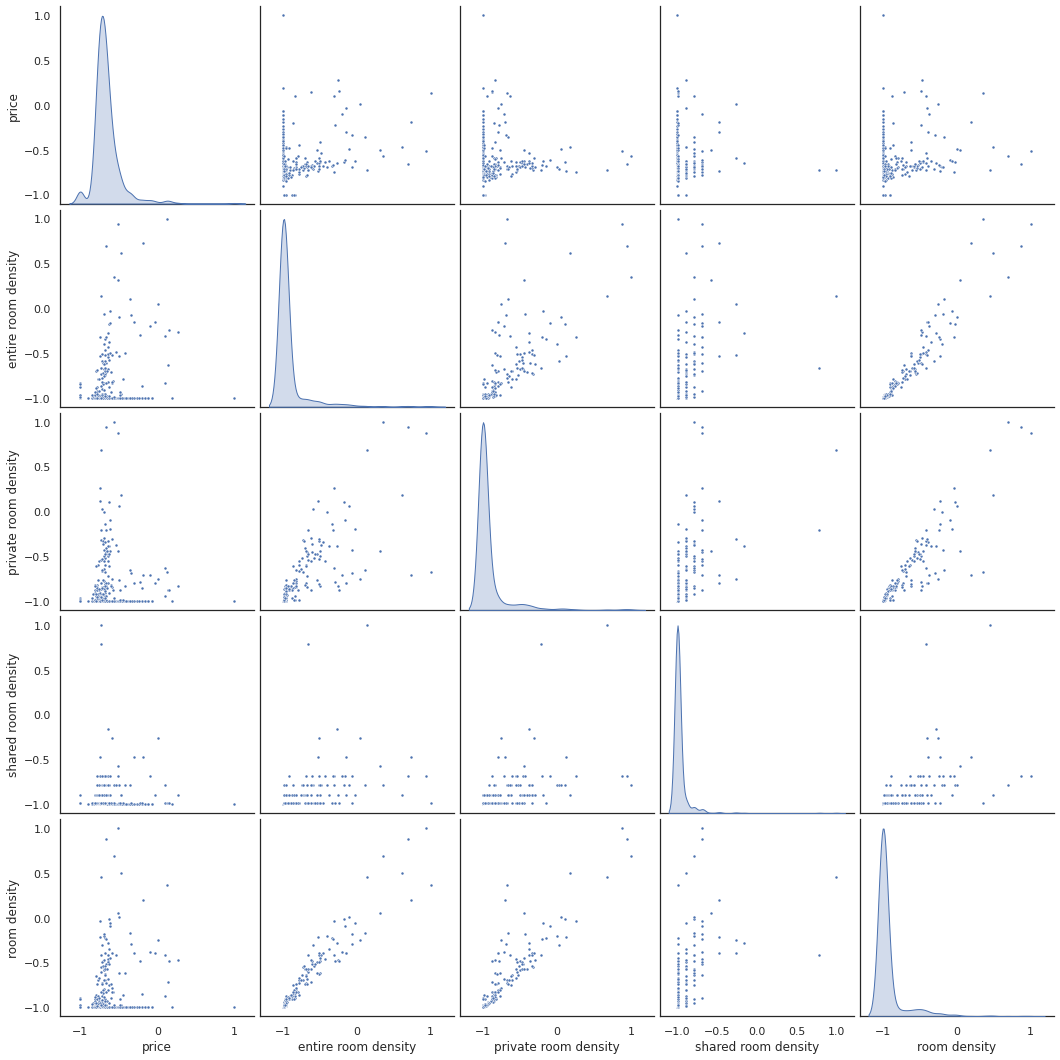

In [61]:
sns.set(style="white")
sns.pairplot(wlg, markers=".", height=3, diag_kind='kde');

In [64]:
for c in wlg.columns.values:
    wlg[c] = mms.fit_transform(wlg[c].values.reshape(-1,1))
wlg.head(3)

,price,entire room density,private room density,shared room density,room density
GSS_CODE,,,,,
E05000026,-0.841935,-0.999998,-0.999997,-0.999996,-0.999998
E05000027,-0.800581,-1.000000,-0.999999,-1.000000,-0.999999
E05000028,-0.800000,-0.999999,-1.000000,-1.000000,-1.000000


In [66]:
wlg = pd.merge(wlg,dfward, on='GSS_CODE',how = 'left')
wlg = gpd.GeoDataFrame(wlg, crs="EPSG:27700", geometry='geometry').set_index('GSS_CODE')

In [67]:
g_y = wlg['price'].values.reshape((-1,1))
g_X = wlg[['entire room density', 'private room density', 'shared room density']].values
u = wlg.centroid.x
v = wlg.centroid.x
g_coords = list(zip(u,v))

In [68]:
# Select bandwidth for kernel
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y, # Independent variable
                  g_X, # Dependent variable
                  fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
                  spherical=True) # Spherical coordinates (long-lat) or projected coordinates

# Can you calculate the optimum bandwidth for our local regression?
bw.search()

652.0

In [69]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

191.0


In [70]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 657
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             16.567
Log-likelihood:                                                     276.725
AIC:                                                               -545.451
AICc:                                                              -543.358
BIC:                                                              -4219.891
R2:                                                                   0.174
Adj. R2:                                                              0.170

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [71]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = gwr_results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = gwr_results.filter_tvals(alpha=.1)
filtered_estimates99 = gwr_results.filter_tvals(alpha=.01)

# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(gwr_results.localR2)# Create the new dataframe


In [72]:
df1=pd.DataFrame(wlg["NAME"])
df2 = df1.assign(entire_room_density=data_params[1],
                 private_room_density=data_params[2],
                 shared_room_density=data_params[3],
                 localR2=data_localR2[0])
df2.columns
df2

,NAME,entire_room_density,private_room_density,shared_room_density,localR2
GSS_CODE,,,,,
E05000026,Abbey,NaN,NaN,NaN,NaN
E05000027,Alibon,NaN,NaN,NaN,NaN
E05000028,Becontree,NaN,NaN,NaN,NaN
E05000029,Chadwell Heath,NaN,NaN,NaN,NaN
E05000030,Eastbrook,NaN,NaN,NaN,NaN
...,...,...,...,...,...
E05011485,South Norwood,NaN,NaN,NaN,NaN
E05011486,Thornton Heath,NaN,NaN,NaN,NaN
E05011487,Waddon,NaN,NaN,NaN,NaN


In [73]:
# Merge our shapefile with the model's results
dfward = dfward.merge(df2, on = 'GSS_CODE')
dfward.head()

,NAME_x,GSS_CODE,geometry,NAME_y,entire_room_density,private_room_density,shared_room_density,localR2
0,Chessington South,E05000405,"POLYGON ((516401.596 160201.802, 516407.302 16...",Chessington South,NaN,NaN,NaN,NaN
1,Tolworth and Hook Rise,E05000414,"POLYGON ((519552.998 164295.600, 519508.096 16...",Tolworth and Hook Rise,NaN,NaN,NaN,NaN
2,Berrylands,E05000401,"POLYGON ((518107.499 167303.399, 518114.301 16...",Berrylands,NaN,NaN,NaN,NaN
3,Alexandra,E05000400,"POLYGON ((520336.700 165105.498, 520332.198 16...",Alexandra,NaN,NaN,NaN,NaN
4,Beverley,E05000402,"POLYGON ((521201.203 169275.505, 521204.303 16...",Beverley,NaN,NaN,NaN,NaN


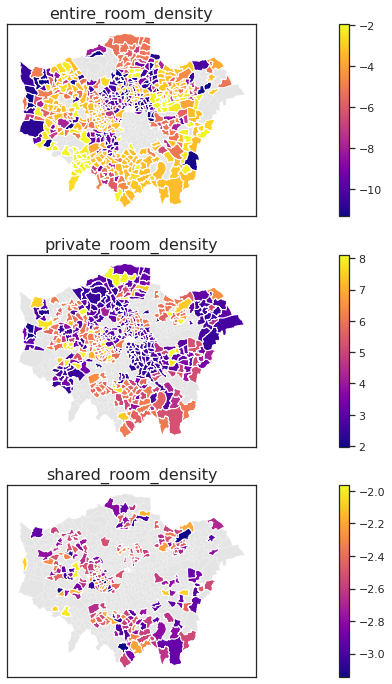

In [76]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(3,1,figsize=(30,12), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['entire_room_density','private_room_density','shared_room_density']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T[1:4]):
    # We want to plot all the non-significant estimates in grey
    ct_temp = dfward.assign(toplot=filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
     
plt.show()
    